## 1. Transfer Learning for CNNs

In [10]:
import time

from tqdm import tqdm  # Progress bar

import numpy as np

import torch

import torchvision
from torchvision.datasets import ImageNet
from torchvision.models.vgg import vgg11, vgg11_bn
from torchvision.models.resnet import resnet18, resnet34
from torchvision.models.densenet import densenet121
from torchvision.models.mobilenetv3 import mobilenet_v3_small

import matplotlib.pyplot as plt

import cifar100_utils

### Question 1.1

a) (4 points) Plot for VGG11, VGG11 with batch normalization, ResNet18,
ResNet34, DenseNet121 and MobileNet-v3-Small, the Top-1 accuracy on ImageNet
vs the inference speed. The value for the Top-1 accuracy of each model can be
found on the PyTorch website. Also plot the inference speed vs the number
of parameters. Does it scale proportionately? Make sure to set the model on
evaluation mode, use torch.no_grad() and a GPU. Report the inference
speed in ms for one image. Average the inference speed across multiple forward
passes. Shortly, describe the trends you observe.

b) (2 points) Do you expect the inference speed to increase or decrease without
torch.no_grad()? Why? What does torch.no_grad() do? For the same
models as in (a), plot the inference speed with and without torch.no_grad().

c) (2 points) For the same models as in (a), plot the amount of GPU vRAM (you
can check this with code by executing torch.cuda.memory_allocated()
or with the terminal using nvidia-smi) while conducting a forward pass
with torch.no_grad() and without. Does torch.no_grad() influence the
memory usage? Why? Make sure to save the output after the forward pass. Use
batch_size=64 and report the memory in MB.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}')
print()

# Generate fake dataset
torch.manual_seed(14334739)
test_images = torch.rand((256, 3, 32, 32))
test_labels = torch.zeros(256)

# Load pre-trained models
model_list = [vgg11(), vgg11_bn(), resnet18(), resnet34(), densenet121(), mobilenet_v3_small()]
model_labels = ['VGG11', 'VGG11 with BatchNorm', 'ResNet18', 'ResNet34', 'DenseNet121', 'MobileNet-v3-Small']

GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU



In [44]:
def eval_models(model_list, test_images, test_labels, batch_size, no_grad=True):

    # Create dataloader
    test_loader = [(test_images[i*batch_size:(i+1)*batch_size,:,:], test_labels[i*batch_size]) for i in range(int(len(test_labels) / batch_size))]

    # Metric lists
    acc_list = [69.02, 70.37, 69.758, 73.314, 74.434, 67.668]  # From https://pytorch.org/vision/stable/models.html
    speed_list = []
    param_list = []

    # Evaluate models
    print('Evaluating models...')
    for i, model in enumerate(model_list):  # For each model
        print(f'   {model_labels[i]}')
        model_speed_list = []  # Inference speed calculations for the model

        for inputs, targets in test_loader:  # For each batch

            # Send data and model to GPU
            inputs = inputs.to(device)
            targets = targets.to(device)
            model.to(device)

            # Test model
            model.eval()
            if no_grad:
                torch.no_grad()
            start = time.process_time()*1000  # Elapsed time in milliseconds
            predictions = model(inputs)
            end = time.process_time()*1000

            # Append speed calculations to list
            model_speed_list.append((end - start) / batch_size)  # Divide by batch size to get inference speed for one image

        # Get model metrics
        speed_list.append(np.mean(model_speed_list))
        param_list.append(sum(p.numel() for p in model.parameters()))  # Count model parameters

    return acc_list, speed_list, param_list

In [45]:
# Question 1.1.a

# Evaluate models
acc_list, speed_list, param_list = eval_models(model_list, test_images, test_labels, batch_size=1)

Evaluating models...
   VGG11
   VGG11 with BatchNorm
   ResNet18
   ResNet34
   DenseNet121
   MobileNet-v3-Small


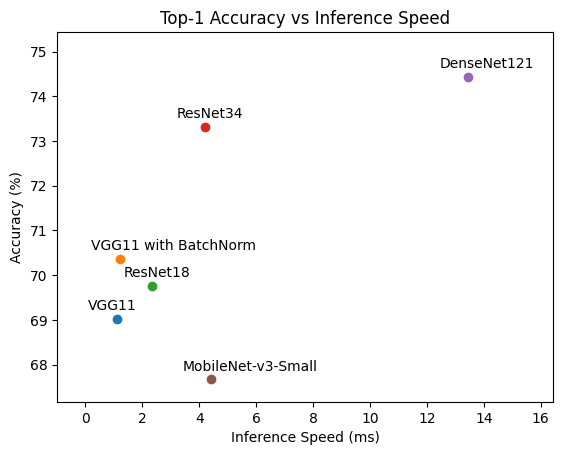

In [47]:
# Plot Accuracy vs Inference speed
plt.title('Top-1 Accuracy vs Inference Speed')
plt.xlabel('Inference Speed (ms)')
plt.ylabel('Accuracy (%)')
plt.xlim(-1,max(speed_list)+3)
plt.ylim(min(acc_list) - 0.5, max(acc_list) + 1)
for i in range(len(acc_list)):
    plt.scatter(speed_list[i], acc_list[i])
    plt.annotate(model_labels[i],(speed_list[i] - 1, acc_list[i] + 0.2))

plt.show()

In [ ]:
train_set, val_set = cifar100_utils.get_train_validation_set('./data')
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = cifar100_utils.get_test_set('./data')
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)